In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import pandas

In [3]:
df = pandas.read_csv('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv', header=None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 359.3 MB


In [6]:
import matplotlib.pyplot as plt

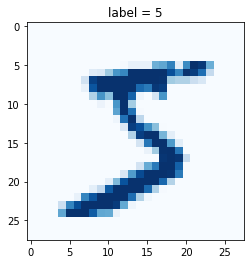

In [7]:
row = 0
data = df.iloc[row]

#첫번째 값은 레이블
label = data[0]

#이미지 데이터는 나머지 784개의 값
img = data[1:].values.reshape(28, 28)
plt.title("label = " + str(label))
plt.imshow(img, interpolation='none', cmap = 'Blues')
plt.show()

In [8]:
import torch
import torch.nn as nn

In [9]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(784, 200), nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200,10), nn.LeakyReLU(0.02)
    )

    self.loss_function = nn.MSELoss(0.02)

    self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

    self.counter = 0
    self.progress = []

    pass
  
  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):
    outputs = self.forward(inputs)

    loss = self.loss_function(outputs, targets)

    #각 노드마다 오차기울기를 계산하고, 노드에 연결된 가중치 수정
    self.optimiser.zero_grad()#기울기 초기화
    loss.backward()#역전파 실행
    self.optimiser.step()#가중치 갱신

    self.counter += 1
    if(self.counter%10 == 0):
      self.progress.append(loss.item())
      pass

    if(self.counter %10000 == 0):
      print("counter = ", self.counter)
      pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])#차트로 쉽게 나타내기 위해 손실값을 저장해둔 리스트를 팬더스 데이터프레임으로 변환
    df.plot(ylim = (0, 1.0), figsize = (16, 8), alpha = 0.1, marker='.', grid = True, yticks = (0, 0.25, 0.5))#plot함수의 옵션으로 여러 스타일과 디자인 지정
    pass

In [10]:
from torch.utils.data import Dataset

In [11]:
class MnistDataset(Dataset):
  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header = None)
    pass

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, index):
    label = self.data_df.iloc[index, 0]
    target = torch.zeros((10))
    target[label] = 1.0

    image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values)#각 픽셀을 255로 나눔 -> 정규화, 0~1사이의 값을 갖는다
    
    return label, image_values, target

  def plot_image(self, index):
    img = self.data_df.iloc[index,1:].values.reshape(28, 28)
    plt.title("label = " + str(self.data_df.iloc[index, 0]))
    plt.imshow(img, interpolation = 'none', cmap = "Blues")
    #plt.show()
    pass

  pass

In [12]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')

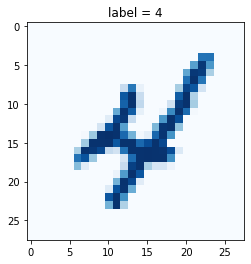

In [13]:
mnist_dataset.plot_image(9)

In [14]:
mnist_dataset[100]

(5,
 tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0

In [15]:
C = Classifier()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [16]:
#for label, image_data_tensor, target_tensor in mnist_dataset:
#  C.train(image_data_tensor, target_tensor)
#  pass

In [17]:
%%time
C = Classifier()

epochs = 3

for i in range(epochs):
  print("training epoch =", i+1, "of", epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)
    pass
  pass

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


training epoch = 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch = 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch = 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 3min 57s, sys: 3.04 s, total: 4min
Wall time: 4min


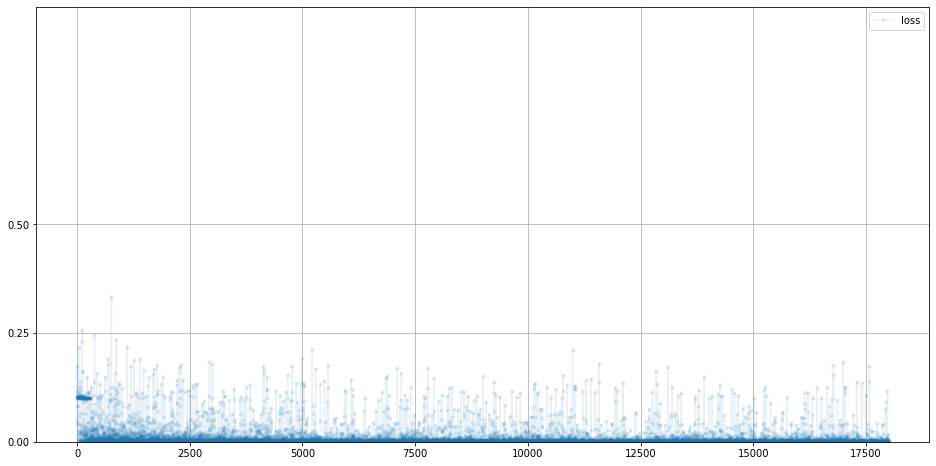

In [18]:
C.plot_progress()

In [19]:
mnist_test_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_test.csv')

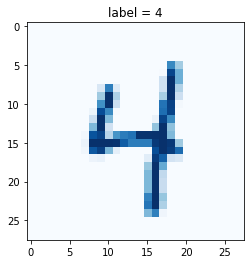

In [20]:
record = 19

mnist_test_dataset.plot_image(record)

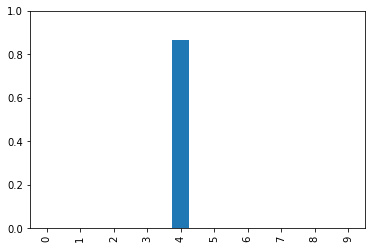

In [21]:
image_data = mnist_test_dataset[record][1]

output = C.forward(image_data)

pandas.DataFrame(output.detach().numpy()).plot(kind = 'bar', legend = False, ylim=(0, 1))

In [22]:
score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
  answer = C.forward(image_data_tensor).detach().numpy()
  if(answer.argmax() == label):
    score += 1
    pass
  items += 1

  pass

print(score, items, score/items)

9745 10000 0.9745
